<table>
    <tr>
        <td><img src="./Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Inteligencia Artificial</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Notebook</p></tp>
            <tp><p style="font-size:150%;text-align:center">Resolución del problema del mundo de los bloques</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

## Integrantes
Juan Diego Martínez y Laura Valentina Hernández

### Librerias de python y del notebook

In [1]:
from AmbientesMP import *
from busqueda import *
from collections import namedtuple
from collections import Counter
from tiempos import compara_funciones
from testSuits import test_suit_heuristicas
import operator
import seaborn as sns
from random import choice
import numpy as np
import plotly.express as px


import pandas as pd

## Objetivo <a class="anchor" id="inicio"></a>

En este notebook se explicarán las heurísticas desarrolladas para disminuir el tiempo de CPU que le toma a los algoritmos informados resolver el problema del mundo de los bloques y se realizará un compración de los algortimos de búsqueda, tanto informada como a ciegas.

**Búsqueda a ciegas**

Primero vamos a probar la solución de este problema con los algoritmos Primero en anchura, Primero en profundidad y Backtracking.

Para este problema se empieza desde n = 3, para que el problema pueda tener coherencia y solución.

In [9]:
prob = BlockWorld(3)
prob2 = BlockWorld(4)
prob3 = BlockWorld()


In [10]:
funs = [anchura,
        profundidad,
        lambda problema: backtracking(problema, Nodo(problema.estado_inicial, None, None, 0, problema.codigo(problema.estado_inicial)))]
args = [[prob],[prob],[prob]]
args2 = [[prob2],[prob2],[prob2]]
args3 = [[prob3],[prob3],[prob3]]
nombres = ['Primero en anchura', 
           'Primero en profundidad', 
           'Backtracking']
data = compara_funciones(lista_funs=funs, 
                         lista_args=args, 
                         lista_nombres=nombres, 
                         num_it=10)
data2 = compara_funciones(lista_funs=funs, 
                         lista_args=args2, 
                         lista_nombres=nombres, 
                         num_it=10)


Para n=3 obtenemos

In [11]:
data.groupby('Función').agg({'tiempo_CPU':['mean', 'std']})

tiempo_CPU          
                             mean       std
Función                                    
Backtracking             0.002824  0.005997
Primero en anchura       0.013417  0.006752
Primero en profundidad   0.001861  0.004757

<Axes: xlabel='Función', ylabel='tiempo_CPU'>

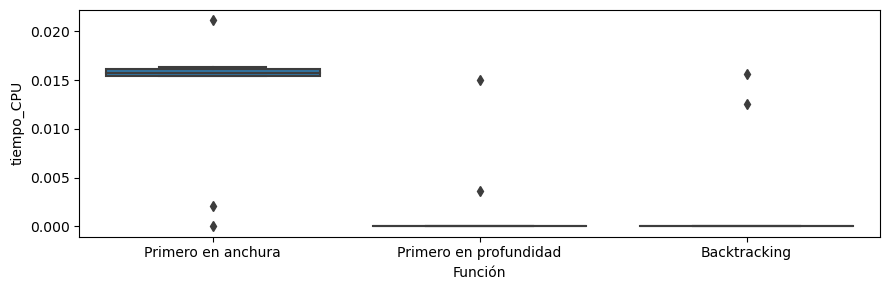

In [12]:
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data, x='Función', y='tiempo_CPU')

Para n=4 obtenemos

In [13]:
data2.groupby('Función').agg({'tiempo_CPU':['mean', 'std']})

tiempo_CPU          
                             mean       std
Función                                    
Backtracking             0.001563  0.004943
Primero en anchura       0.003138  0.005939
Primero en profundidad   0.117079  0.008176

<Axes: xlabel='Función', ylabel='tiempo_CPU'>

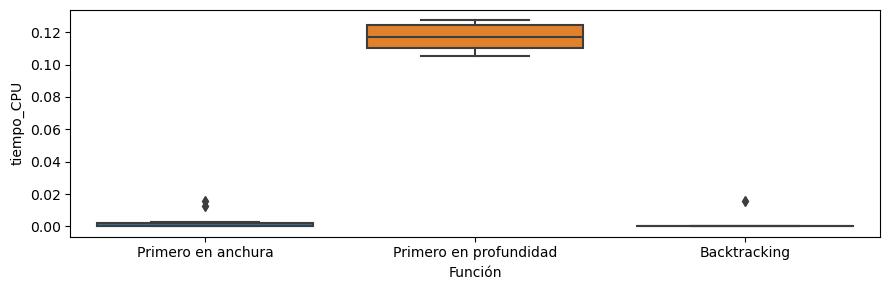

In [14]:
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data2, x='Función', y='tiempo_CPU')

Ahora vamos a evaluar con n = 5.

In [15]:
#data3 = compara_funciones(lista_funs=funs,  lista_args=args3, lista_nombres=nombres,  num_it=10)

Note que al correr esa celda, al igual que con ns mayores, los algoritmos de búsqueda a ciegas se demoran mucho en encontrar la solución. Es decir, hay una maldición de la dimensionalidad con un n>=5. Ahora vamos a intentar solucionar esto defininiendo las heurísticas

### Heurísitica 1

Para poder implementar la heurística 1 definimos la función encima, la cual para el estado recibido, toma cada bloque y devuelve cuántos bloques están encima de él en formato lista.

In [16]:
def encima(self,estado:np.matrix):
    
    l= [] 
    for i in range(1,self.num_de_blocks+1):
        f,c = np.where(estado == i)
        f = f[0]
        c = c[0]
        b = estado[:,c]
        b = b[0:f]
       
        #se cuenta cuántos elementos no cero hay en b,que representa
        #cuántos bloques hay encima del bloque actual en esa columna
        l.append( np.count_nonzero(b !=0))

        
    return l              
    

La heurística 1 consiste en evalúar lo siquiente para cada bloque:
  * Si está en la posición correcta
  * La distancia que hay entre ese bloque y su posición final
  
Después de iterar sobre todos los bloques, se llama a la función encima(estado) para determinar la cantidad de bloques que hay encima de cada bloque en el estado actual y final. Luego, se obtiene la diferencia para cada bloque y se añadé al valor final.



In [17]:
def piezas_y_distancia(self,estado:np.matrix):
    
    objetivo = self.estado_final
    c = 0
    l=[]
    for a in range(1,self.num_de_blocks+1):
            
               of,oc = np.where(objetivo == a)
               ef,ec =  np.where(estado == a)
            
               if of.size > 0 and ef.size > 0:
                    #se determinan la posición del bloque en el estado actual y en el estado final
                     of = int(of[0])
                     oc = int(oc[0])
                     ef = int(ef[0])
                     ec = int(ec[0])
                     
                     if objetivo[of,oc]!=estado[of,oc]:
                        #se obtiene la distancia de la pos actual a la final
                        c = c+1+abs(of-ef)+abs(oc-ec)
                        
                        
                              
                     else:
                        
                        if of==estado.shape[0]-1:
                            #Si el bloque se encuentra en la última fila(piso) del estado actual y 
                            #está en la posición correcta, se disminuye el contador .
                            w=2.5
                            c-=10*w
                        
                        c-=2
     
    #Se determina la cantidad de bloques que hay encima del bloque que se está trabjando en cada estado
    le = self.encima(estado)
    lo = self.encima(objetivo)                
    ld = sum(map(abs, map(operator.sub, s1.encima(s1.estado_inicial), s1.encima(s1.estado_final))))
    c+= ld
                        
                        
                        
    return c
    
    

Se añadieron las funciones a la clase

In [18]:
setattr(BlockWorld, 'encima', encima)
setattr(BlockWorld, 'heuristica1', piezas_y_distancia)

### Heurísitica 2

Para poder implementar la heurística 2 definimos las funciones sup y correctas


La función sup determina en el estado los bloques que se pueden mover, es decir los bloques superiores

In [19]:
def sup(self,m):
    l =[]
    for a in range(1,self.num_de_blocks+1):
          of, oc = np.where(m == a)  
          if of.size>0 and oc.size>0:
            
             if of-1==-1:
                l.append(int(m[of,oc]))
                
             if of-1>-1 and m[of-1,oc]==0:
                
                 l.append(int(m[of,oc]))
    return l
               

La función correctas  a partir de un bloque verifica de abajo hacia arriba cuántos bloques debajo de él son correctos

In [20]:
def correctas(self,m,o,f,c):
    
    k= self.num_de_blocks
    n=0
    while k>f:
        
        if m[k-1,c]==o[k-1,c]:
            #al bloque que esté en la pos correcta con su inferior también en la pos correcta
            #se le da un valor alto para que no se mueva ese bloque
            n-=100
            k-=1

        else:
            
            #a penas encuentre un bloque mal posicionado deja de verificar
            return n,False
    return n,True
    

Se definió la heuristica 2 a continuación

In [21]:
 def piezas_con_pesos(self, estado:np.matrix):
        
        
        objetivo = self.estado_final
        c = 0
        
        # se itera sobre el número de bloques y no sobre toda la matriz, pues se tienen n*n posiciones de las cuales solo son de
        # interes n (en un caso de 10 bloques, hay 90 posiciones que tienen cero y solo 10 tiene bloques)
        
        l = self.sup(estado)
        for a in range(1,self.num_de_blocks+1):
            
               of,oc = np.where(objetivo == a)
               ef,ec =  np.where(estado == a)
            
               if of.size > 0 and ef.size > 0:
                    #se determinan la posición del bloque en el estado actual y en el estado final
                     of = int(of[0])
                     oc = int(oc[0])
                     ef = int(ef[0])
                     ec = int(ec[0])
                    
                     #se suma correctas para que evite mover las piezas que ya están en su posición final
                    
                     c+= self.correctas(estado,objetivo,of,oc)[0]
                        
                     #si el bloque y todos sus  inferiores no están en ubicados en la pos final:
                    
                     if  not self.correctas(estado,objetivo,of,oc)[1]:

                       if objetivo[of,oc]!=estado[of,oc]:
                           if a in l:
                            # si el bloque es superior, se verifica si su pos final está vacía
                                    if estado[of,oc] == 0:
                                       
                                        if of == self.num_de_blocks-1:
                                             #se prioriza liberar las posiciones de los bloques libres que van en el suelo
                                             c = c-of-5

                                        elif estado[of+1,oc]!=0 and estado[of+1,oc]!=a :
                                            c = c-of-1
                                      
                           else:
                                # si no es un bloque sup se le suma uno a su posición y se duplica este valor
                                # para sumarlo a c, esto con el fin de darle más peso a los bloques que esten mal puestos
                                #de abajo hacia arriba,
                               
                                c+= (ef+1)*2
                                      

                               # sin importar si el bloque es libre o no, se le suma uno si está en la col incorrecta
                               #y otro más si está en la fila incorrecta
                           if ef != of and ec != oc :
                                        c = c + 2

                           else:
                                   c= c+1
                     
                     

                
        return int(c)

Se añadieron las funciones a la clase

In [22]:
setattr(BlockWorld, 'sup', sup)
setattr(BlockWorld, 'heuristica2',  piezas_con_pesos)
setattr(BlockWorld, 'correctas', correctas)

## Prueba  de las heurísticas

Ahora vamos a volver a intentar resolverlo con n = 5

<Axes: >

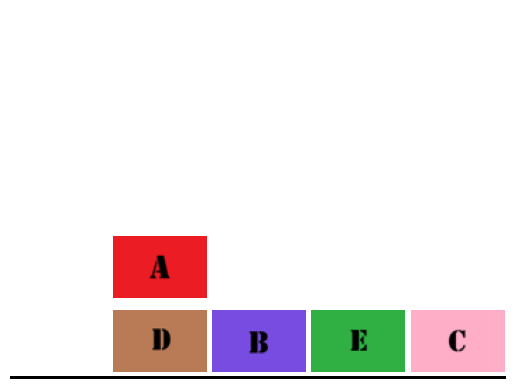

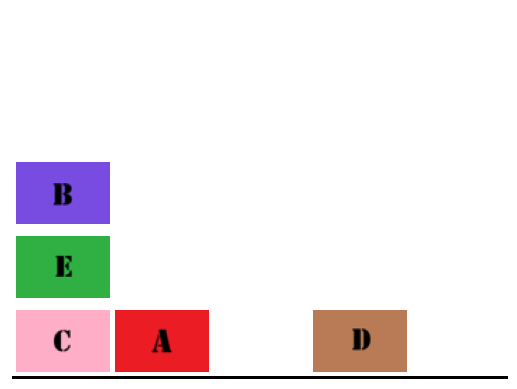

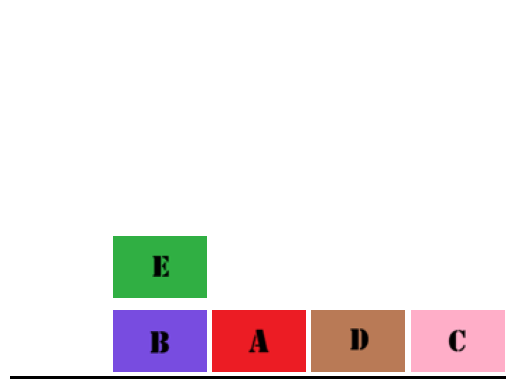

In [23]:
#casos de prueba

dim = 5

s1 =BlockWorld(dim)
s2 = BlockWorld(dim)
s3 = BlockWorld(dim)
s1.pintar_estado(s1.estado_inicial)
s2.pintar_estado(s2.estado_inicial)
s3.pintar_estado(s3.estado_inicial)

Vamos a evaluarlo para los algortimos de búsqueda informada

In [27]:
estados = [s1.estado_inicial,s2.estado_inicial,s3.estado_inicial]

# Definimos las heurísticas
heuristicas = [piezas_y_distancia, piezas_con_pesos]

nombres = ['piezas_y_distancia', 'piezas_con_pesos']

# Creamos el test suite
lista_tests, lista_nombres = test_suit_heuristicas(estados, heuristicas, nombres)
lista_funs = [A_star]*len(lista_tests)
lista_funs2 = [avara]*len(lista_tests)

Para el algoritmo A* obtenemos

In [28]:

data3 = compara_funciones(lista_funs=lista_funs, 
                         lista_args=lista_tests, 
                         lista_nombres=lista_nombres, 
                         num_it=10)
data3.groupby('Función').agg({'tiempo_CPU':['mean', 'std']})

tiempo_CPU          
                         mean       std
Función                                
piezas_con_pesos     0.047375  0.016170
piezas_y_distancia   0.266233  0.132929

<Axes: xlabel='Función', ylabel='tiempo_CPU'>

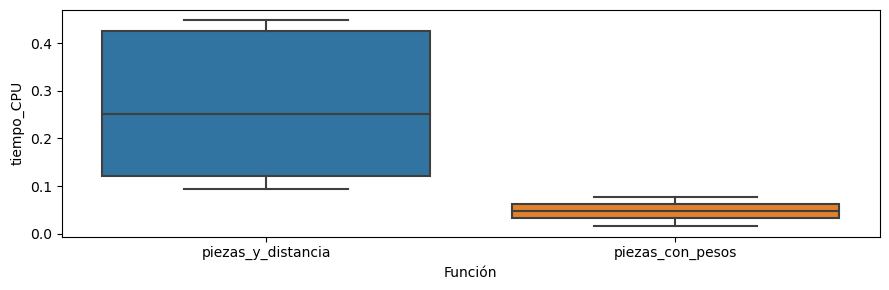

In [29]:
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data3, x='Función', y='tiempo_CPU')

Para el algortimo ávara tenemos

In [30]:
data4 = compara_funciones(lista_funs=lista_funs2, 
                         lista_args=lista_tests, 
                         lista_nombres=lista_nombres, 
                         num_it=10)
data4.groupby('Función').agg({'tiempo_CPU':['mean', 'std']})


tiempo_CPU          
                         mean       std
Función                                
piezas_con_pesos     0.042601  0.012917
piezas_y_distancia   0.179620  0.067488

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data4, x='Función', y='tiempo_CPU')

Ahora para n>5 en las siguientes gráficas se puede evidenciar cómo la dimensionalidad va afectando los tiempos.

Aquí se presentan promedios de los tiempos con diferentes estados iniciales, principalmente con la heurística 1 que es la que presentó más diferencias, puesto que como los estados siempre son aleatorios, se puede tener un caso  de dimensionalidad nueve donde el tiempo sea 0.01, pues el estado inicial está cerca al final, y también se puede tener un caso donde el tiempo sea 3.14

In [ ]:
data =[[3,0.001563,0.05764],[4,0.022083,0.012943],[5,0.0130,0.056],[6,0.0245,0.031],[7,0.066,0.561],[8,0.3232,0.42],[9,0.5184,1.34],[10,0.773,1.945]]

df = pd.DataFrame(data, columns=['Dimensionalidad','Heurística 2','Heurística 1'])
fig = px.line(df, x="Dimensionalidad", y="Heurística 1", title='Algoritmo A*')
fig.add_scatter(x=df['Dimensionalidad'], y=df['Heurística 2'])
fig.show()
print("la heurística 1 es la línea de color azul, la heurística dos la línea de color naranja")

print(df)

In [ ]:
data =[[3,0.001562,0.003877],[4,0.002604,0.011060],[5,0.010,0.048],[6,0.024,0.024],[7,0.060,0.403],[8,0.28,0.38],[9,0.564,0.879],[10,0.768,1.87]]

df = pd.DataFrame(data, columns=['Dimensionalidad','Heurística 2','Heurística 1'])
fig = px.line(df, x="Dimensionalidad", y="Heurística 1", title='Algoritmo ávara')
fig.add_scatter(x=df['Dimensionalidad'], y=df['Heurística 2'])
fig.show()
print("la heurística 1 es la línea de color azul, la heurística dos la línea de color naranja")
print(df)

Ahora se presenta una tabla con el tiempo de CPU que le toma a cada algoritmo resolver el problema en  las dimensiones

In [32]:
avara =[[3,0.001562,0.003877],[4,0.002604,0.011060],[5,0.010,0.048],
        [6,0.024,0.024],[7,0.060,0.403],[8,0.28,0.38],
        [9,0.564,0.879],[10,0.768,1.87]]
dfA = pd.DataFrame(avara, columns=['dimension', 'pesos', 'distancia'])
dfA = dfA.set_index('dimension')

Star =[[3,0.001563,0.05764],[4,0.022083,0.012943],[5,0.0130,0.056],
       [6,0.0245,0.031],[7,0.066,0.561],[8,0.3232,0.42],
       [9,0.5184,1.34],[10,0.773,1.945]]
dfS = pd.DataFrame(Star, columns=['dimension', 'pesos', 'distancia'])
dfS = dfS.set_index('dimension')


df_total = pd.merge(dfA, dfS, on='dimension', suffixes=('_avara', '_star'))

Back= [[3, 0.002388, np.nan], [4, 1.054067, np.nan], [5, np.nan, np.nan], [6, np.nan, np.nan], [7, np.nan, np.nan], [8, np.nan, np.nan], [9, np.nan, np.nan], [10, np.nan, np.nan]]
dfB = pd.DataFrame(Back, columns=['dimension', 'CPU', 'distancia'])
dfB = dfB.set_index('dimension')

Anchu= [[3, 0.002314, np.nan], [4, 5.989798, np.nan], [5, np.nan, np.nan], [6, np.nan, np.nan], [7, np.nan, np.nan], [8, np.nan, np.nan], [9, np.nan, np.nan], [10, np.nan, np.nan]]
dfAnchu = pd.DataFrame(Anchu, columns=['dimension', 'CPU', 'distancia'])
dfAnchu = dfAnchu.set_index('dimension')

Profu= [[3, 0.007316, np.nan], [4, 0.960047, np.nan], [5, np.nan, np.nan], [6, np.nan, np.nan], [7, np.nan, np.nan], [8, np.nan, np.nan], [9, np.nan, np.nan], [10, np.nan, np.nan]]
dfProfu = pd.DataFrame(Profu, columns=['dimension', 'CPU', 'distancia'])
dfProfu = dfProfu.set_index('dimension')

df_total['Backtracking'] = dfB['CPU']
df_total['Anchura'] =dfAnchu['CPU']
df_total['Profundidad'] =dfProfu['CPU']
print(df_total)

           pesos_avara  distancia_avara  pesos_star  distancia_star  \
dimension                                                             
3             0.001562         0.003877    0.001563        0.057640   
4             0.002604         0.011060    0.022083        0.012943   
5             0.010000         0.048000    0.013000        0.056000   
6             0.024000         0.024000    0.024500        0.031000   
7             0.060000         0.403000    0.066000        0.561000   
8             0.280000         0.380000    0.323200        0.420000   
9             0.564000         0.879000    0.518400        1.340000   
10            0.768000         1.870000    0.773000        1.945000   

           Backtracking   Anchura  Profundidad  
dimension                                       
3              0.002388  0.002314     0.007316  
4              1.054067  5.989798     0.960047  
5                   NaN       NaN          NaN  
6                   NaN       NaN          N

Note que las heurísticas ayudaron a disminuir la maldición de la dimensionalidad, puesto que se puedo obtener una solución hasta problemas de dimensión 10, mientras que sin las heurísticas no se pudo ni alcanzar la dimensión 5 en un tiempo razonable.

Pese a que las diferencias fueron muy leves hasta la dimensión 6 entre ambas heurísticas, se considera que la heurística 2 es mejor puesto que a medida que aumento la dimensionalidad tuvó un comportamiento similar a uno lineal, mientras que la heuristíca 1 tuvo más variación en esas dimensiones y tomaba más tiempo en procesar, es decir, le heurística 1 depende más del estado inicial y final para determinar el tiempo en CPU, mientras que la heurística 2 mantenía una proporción constante.